In [33]:
import os
import numpy as np
import pandas as pd
from scipy import optimize
from scipy import linalg
from scipy.interpolate import UnivariateSpline
import matplotlib.pyplot as plt
import array as arr
import seaborn as sns
import inverse_method_funs as inv
%matplotlib inline

## Upload required values

In [2]:
fname_EV = 'D:/GLIDER2018/Echosounder/EVexport/Wideband_frequency_response_28AM.csv'
freqs_EV, sv = inv.read_widebandfrequencyresponse(fname_EV, extracols = 2)

In [3]:
fname_sim = '../ZooScatStuff/my_data.feather'
specs, freqs_sim, sig_bs_sim, sig_bs_mean = inv.read_scatteringmodelsimulations(fname_sim, nsim=1000)

Resample the simulation values to match the frequencies of the measured frequencies

In [4]:
sigma_bs = np.zeros([len(freqs_EV),np.shape(sig_bs_sim)[1],len(specs)])
sigma_bs_mean = np.zeros([len(freqs_EV),len(specs)])

for ind_spec in range(0,len(specs)):
    f = UnivariateSpline(freqs_sim,sig_bs_mean[:,ind_spec], k=5)
    sigma_bs_mean[:,ind_spec] = f(freqs_EV)
    for ind_sim in range(0,np.shape(sig_bs_sim)[1]):
        f = UnivariateSpline(freqs_sim,sig_bs_sim[:,ind_sim,ind_spec], k=5)
        sigma_bs[:,ind_sim,ind_spec] = f(freqs_EV)

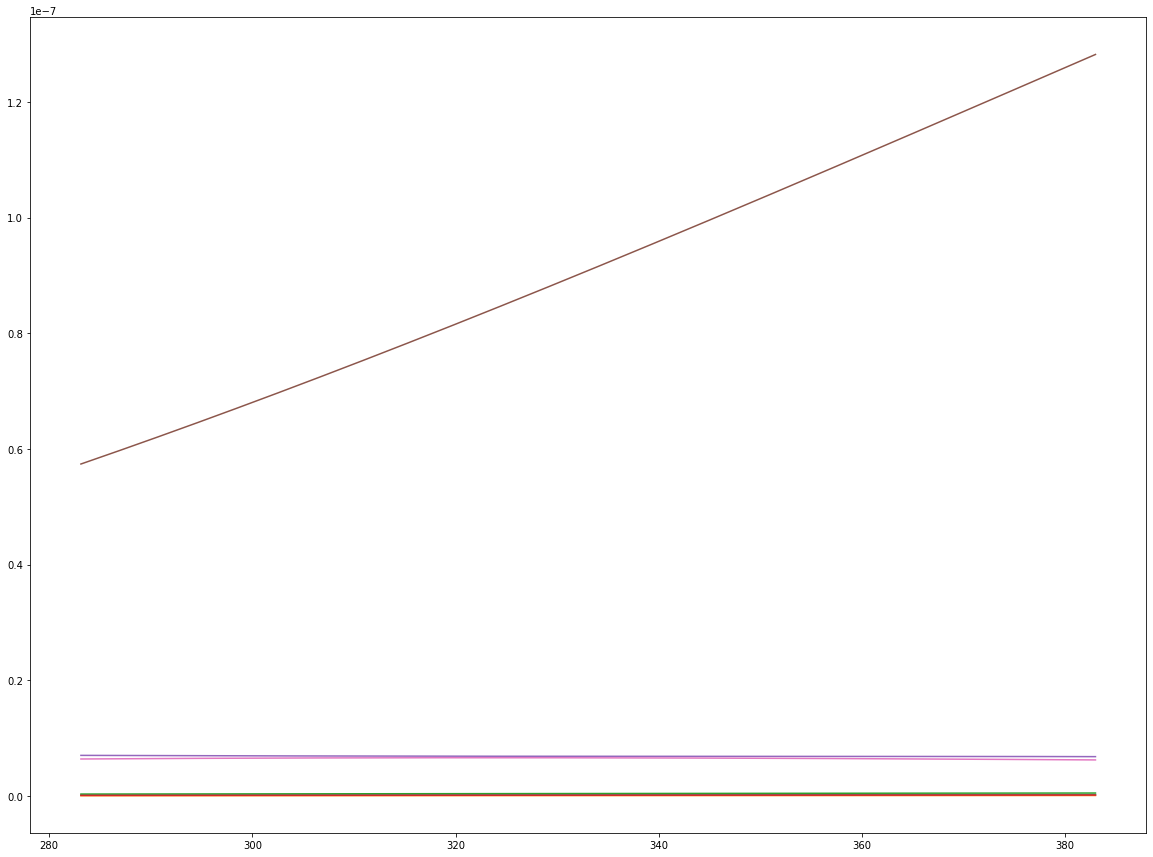

In [44]:
fig=plt.figure(figsize=(20, 15),facecolor='w', edgecolor='k')
plt.plot(freqs_EV,sigma_bs_mean)

In [61]:
density = np.zeros([np.shape(sigma_bs_mean)[1], np.shape(sv)[1]])

for ind in range(0, np.shape(sv)[1]):
    d = optimize.lsq_linear(sigma_bs_mean, arr.array('d',sv[:,ind]), bounds=(0,np.inf))
    print(d.x)
    density[:,ind] = d.x

[4.56935583e+02 9.86277616e+03 5.77557449e+02 2.07543089e+03
 1.39854603e+01 6.61768781e+00 1.11616857e+01]
[5.03647898e+02 1.02226064e+04 5.75559447e+02 2.15681534e+03
 1.47427068e+01 6.86062833e+00 1.13231120e+01]
[4.51953872e+02 9.44135493e+03 5.33000604e+02 1.97358678e+03
 1.33131946e+01 6.35826883e+00 1.03673328e+01]
[4.40679827e+02 9.71096160e+03 5.14219651e+02 1.95929746e+03
 1.21134890e+01 6.72658542e+00 9.28851479e+00]
[4.65636275e+02 9.41809558e+03 5.22792410e+02 1.97982258e+03
 1.34278751e+01 6.34476372e+00 1.02502308e+01]
[4.91416427e+02 9.95274673e+03 5.83837421e+02 2.12855235e+03
 1.50627068e+01 6.60252868e+00 1.18272033e+01]
[5.05278301e+02 1.00533897e+04 5.75878633e+02 2.14154980e+03
 1.51548690e+01 6.68811981e+00 1.16880886e+01]
[5.00777301e+02 9.88044805e+03 5.66568113e+02 2.10577535e+03
 1.49765986e+01 6.56203244e+00 1.15947332e+01]
[4.45211464e+02 1.12285642e+04 5.43273674e+02 2.10912695e+03
 1.14808058e+01 8.18016666e+00 8.73700326e+00]
[4.35776863e+02 9.92608000e+

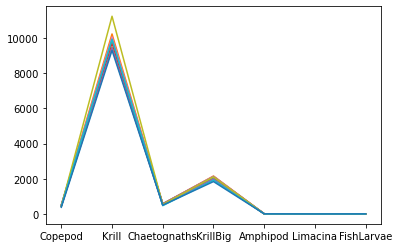

In [63]:
plt.plot(specs,(density))